# Proyek Klasifikasi Gambar: Tomato Leaf Disease
- **Nama:** Achmad Fauzihan Bagus Sajiwo
- **Email:** achmadfauzihanbagussajiwo@gmail.com
- **ID Dicoding:** A296YBF008
- **Link Dataset:** https://www.kaggle.com/datasets/shylesh101/tomato-leaf-disease/data

## Import Semua Packages/Library yang Digunakan

In [31]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 804.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found ex

In [52]:
# Mengimpor libraries umum yang sering digunakan
import os
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

from google.colab import drive

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fauzihanbagus","key":"a41ca0ad4d18b2d5bec83241d5d25763"}'}

In [3]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shylesh101/tomato-leaf-disease
!unzip tomato-leaf-disease.zip -d tomato-leaf-disease

Streaming output truncated to the last 5000 lines.
  inflating: tomato-leaf-disease/tomato_dataset/train/Tomato___healthy/ac022a2b-764c-4507-8dd9-4470b75763e4___RS_HL 9937.JPG  
  inflating: tomato-leaf-disease/tomato_dataset/train/Tomato___healthy/ac249839-fe21-45cd-9e09-f0023fa7ee3a___GH_HL Leaf 273.JPG  
  inflating: tomato-leaf-disease/tomato_dataset/train/Tomato___healthy/acdbf632-8d26-472d-874f-6d7df5cd0432___RS_HL 9897.JPG  
  inflating: tomato-leaf-disease/tomato_dataset/train/Tomato___healthy/acdf2283-0e7c-4ccd-8817-1019e3a8ed20___RS_HL 9943.JPG  
  inflating: tomato-leaf-disease/tomato_dataset/train/Tomato___healthy/acf28842-7821-4f31-ab73-2787e332e852___RS_HL 0011.JPG  
  inflating: tomato-leaf-disease/tomato_dataset/train/Tomato___healthy/ad6857d9-7cf0-42ec-b61b-7b5208863831___RS_HL 0320.JPG  
  inflating: tomato-leaf-disease/tomato_dataset/train/Tomato___healthy/ad8359a4-48b9-4469-a012-ed9b220de38e___GH_HL Leaf 285.1.JPG  
  inflating: tomato-leaf-disease/tomato_dataset/tr

In [4]:
# Baca gambar
img = cv2.imread('tomato-leaf-disease/tomato_dataset/valid/Tomato___Spider_mites Two-spotted_spider_mite/1ff30221-d082-4dd3-ab7b-0028ecf897db___Com.G_SpM_FL 9608_180deg.JPG')

# Ukuran gambar
height, width, channels = img.shape
print("Lebar:", width)
print("Tinggi:", height)
print("Channels (RGB):", channels)

Lebar: 256
Tinggi: 256
Channels (RGB): 3


### Data Combine

In [5]:
# Direktori awal untuk train dan test
path_test = "tomato-leaf-disease/tomato_dataset/test"
path_train = "tomato-leaf-disease/tomato_dataset/train"
path_valid = "tomato-leaf-disease/tomato_dataset/valid"

In [6]:
# Direktori baru untuk dataset gabungan
path_combine = "tomato-leaf-disease/tomato_dataset/dataset"

In [7]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(path_combine, exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(path_test):
    category_dir = os.path.join(path_test, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(path_combine, category), dirs_exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(path_train):
    category_dir = os.path.join(path_train, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(path_combine, category), dirs_exist_ok=True)

# Salin file dan folder dari valid
for category in os.listdir(path_valid):
    category_dir = os.path.join(path_valid, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(path_combine, category), dirs_exist_ok=True)

### Data Visualization

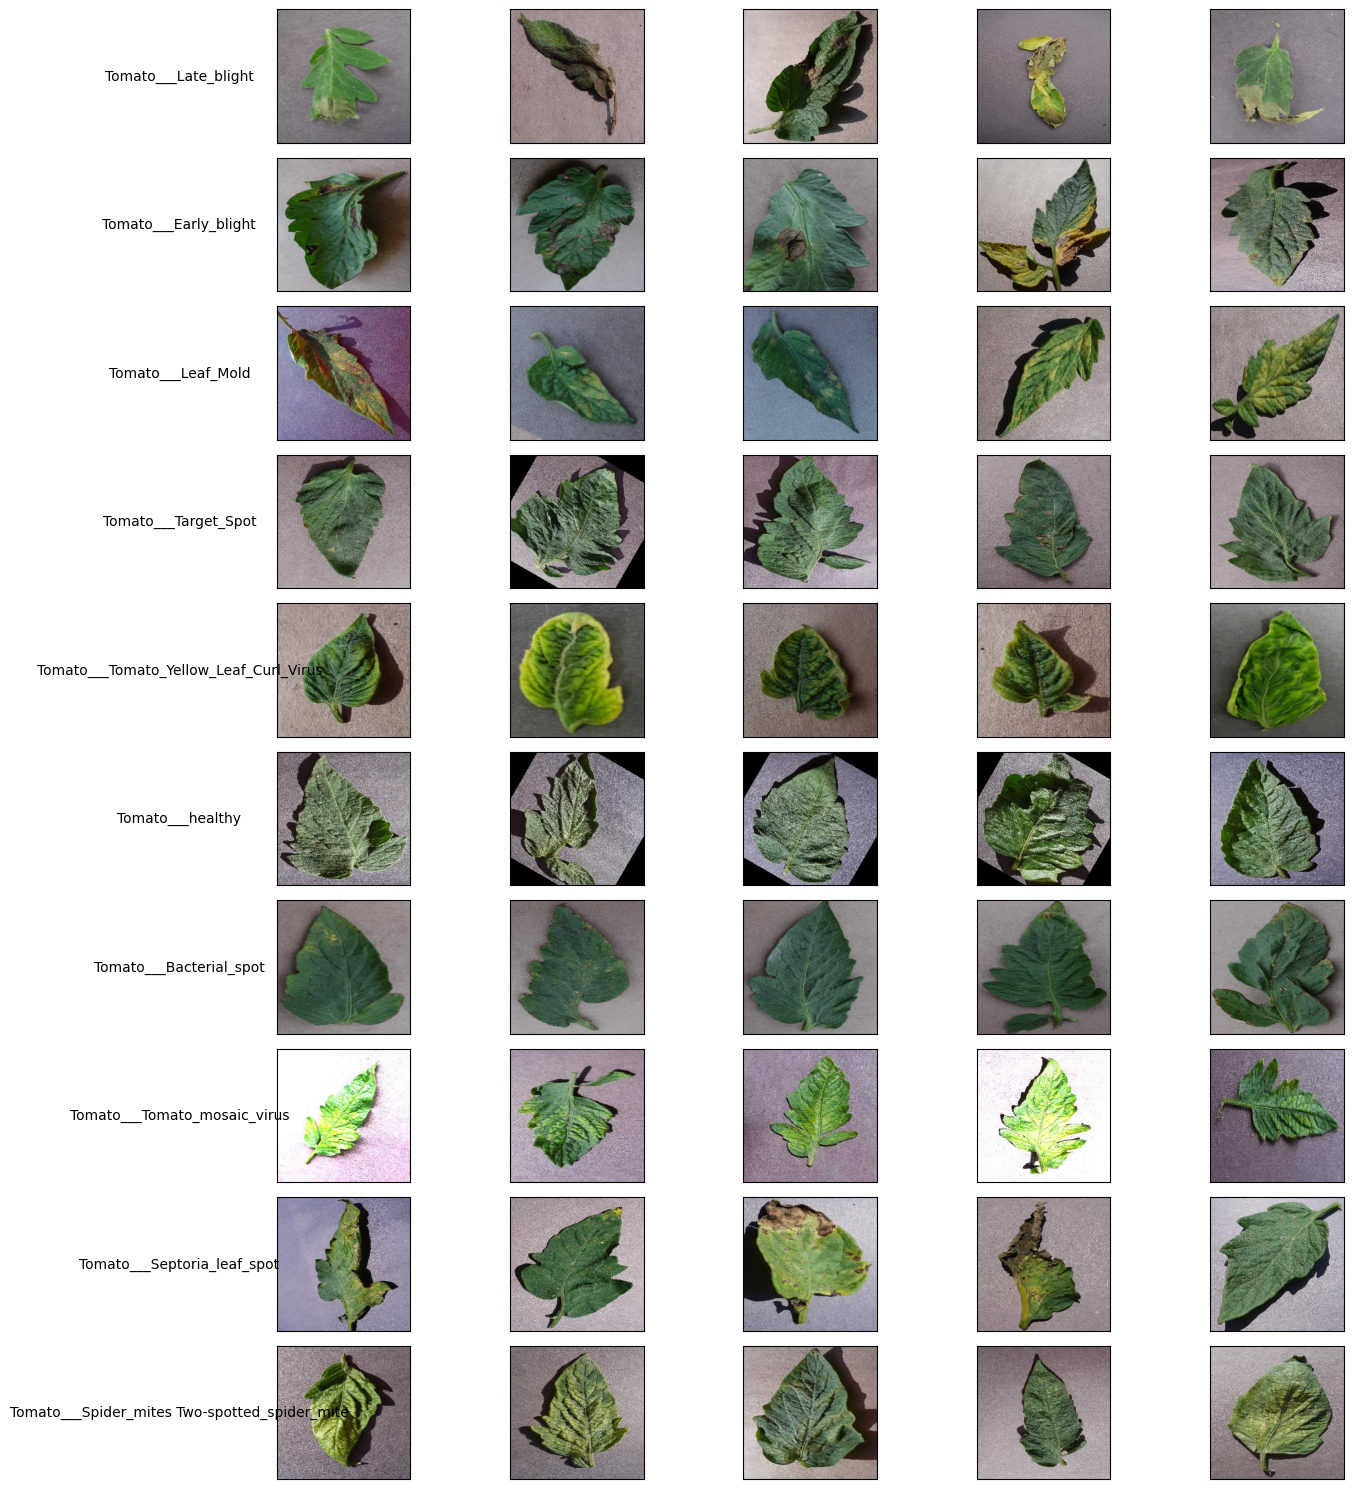

In [8]:
# Membuat kamus untuk menyimpan daftar nama file gambar per kelas
tomato_image = {}

# Path ke folder dataset
dataset_path = "tomato-leaf-disease/tomato_dataset/dataset"

# Kumpulkan nama file gambar berdasarkan kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    tomato_image[class_name] = os.listdir(class_path)

# Visualisasi 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(tomato_image.keys()), 5, figsize=(15, len(tomato_image) * 1.5))

for i, class_name in enumerate(tomato_image.keys()):
    images = np.random.choice(tomato_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

        # Hanya beri label di gambar pertama per baris
        if j == 0:
            axs[i, j].set_ylabel(class_name, fontsize=10, rotation=0, labelpad=70, va='center')

fig.tight_layout()
plt.show()

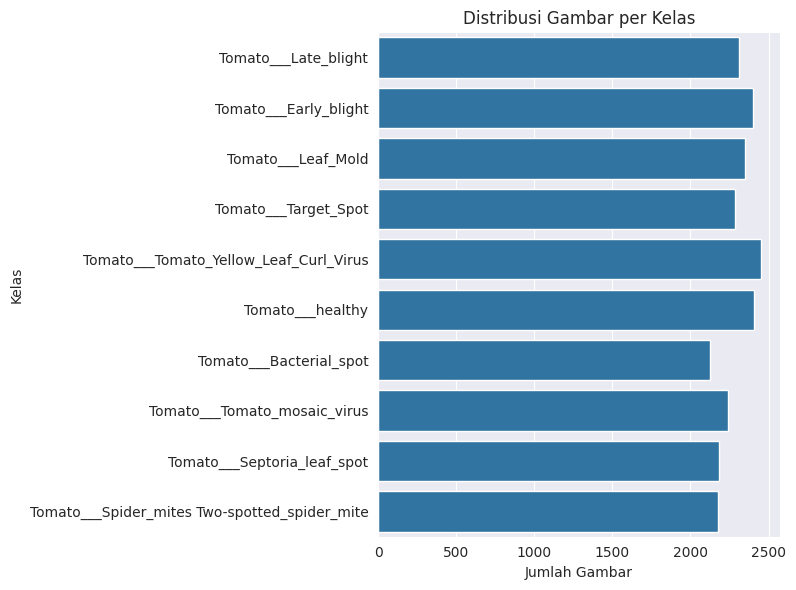

In [9]:
# Define source path
tomato_path = "tomato-leaf-disease/tomato_dataset/dataset"

# Create lists to store file information
file_name = []
labels = []
full_path = []

# Walk through dataset directory
for path, subdirs, files in os.walk(tomato_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # Mengambil nama folder sebagai label
        file_name.append(name)

# Create dataframe
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot the distribution of images across classes (horizontal)
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(y="labels", data=distribution_train)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Kelas")
plt.tight_layout()
plt.show()

In [10]:
# Menghitung jumlah kelas unik
jumlah_kelas = distribution_train['labels'].nunique()
print(f"Jumlah kelas: {jumlah_kelas}")

# Menghitung total jumlah gambar (semua data)
total_data = len(distribution_train)
print(f"\nTotal jumlah data gambar: {total_data}")

# Menghitung jumlah gambar di setiap kelas
jumlah_per_kelas = distribution_train['labels'].value_counts()
print("\nJumlah gambar per kelas:")
print(jumlah_per_kelas)

Jumlah kelas: 10

Total jumlah data gambar: 22930

Jumlah gambar per kelas:
labels
Tomato___Tomato_Yellow_Leaf_Curl_Virus           2451
Tomato___healthy                                 2407
Tomato___Early_blight                            2400
Tomato___Leaf_Mold                               2352
Tomato___Late_blight                             2314
Tomato___Target_Spot                             2284
Tomato___Tomato_mosaic_virus                     2238
Tomato___Septoria_leaf_spot                      2181
Tomato___Spider_mites Two-spotted_spider_mite    2176
Tomato___Bacterial_spot                          2127
Name: count, dtype: int64


### Data Preprocessing

#### Split Dataset

In [11]:
source_dir = 'tomato-leaf-disease/tomato_dataset/dataset'
target_base_dir = 'tomato_dataset_split'

# Train-val-test split ratio
train_ratio, val_ratio = 0.7, 0.15

# Buat folder baru
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(target_base_dir, split, class_name), exist_ok=True)

In [12]:
# Proses split & copy
for class_name in os.listdir(source_dir):
    images = os.listdir(os.path.join(source_dir, class_name))
    train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img_set, split in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
        for img in tq(img_set, desc=f"{split.upper()} - {class_name}"):
            src_path = os.path.join(source_dir, class_name, img)
            dst_path = os.path.join(target_base_dir, split, class_name, img)
            shutil.copy(src_path, dst_path)

TRAIN - Tomato___Late_blight:   0%|          | 0/1619 [00:00<?, ?it/s]

VAL - Tomato___Late_blight:   0%|          | 0/347 [00:00<?, ?it/s]

TEST - Tomato___Late_blight:   0%|          | 0/348 [00:00<?, ?it/s]

TRAIN - Tomato___Early_blight:   0%|          | 0/1680 [00:00<?, ?it/s]

VAL - Tomato___Early_blight:   0%|          | 0/360 [00:00<?, ?it/s]

TEST - Tomato___Early_blight:   0%|          | 0/360 [00:00<?, ?it/s]

TRAIN - Tomato___Leaf_Mold:   0%|          | 0/1646 [00:00<?, ?it/s]

VAL - Tomato___Leaf_Mold:   0%|          | 0/353 [00:00<?, ?it/s]

TEST - Tomato___Leaf_Mold:   0%|          | 0/353 [00:00<?, ?it/s]

TRAIN - Tomato___Target_Spot:   0%|          | 0/1598 [00:00<?, ?it/s]

VAL - Tomato___Target_Spot:   0%|          | 0/343 [00:00<?, ?it/s]

TEST - Tomato___Target_Spot:   0%|          | 0/343 [00:00<?, ?it/s]

TRAIN - Tomato___Tomato_Yellow_Leaf_Curl_Virus:   0%|          | 0/1715 [00:00<?, ?it/s]

VAL - Tomato___Tomato_Yellow_Leaf_Curl_Virus:   0%|          | 0/368 [00:00<?, ?it/s]

TEST - Tomato___Tomato_Yellow_Leaf_Curl_Virus:   0%|          | 0/368 [00:00<?, ?it/s]

TRAIN - Tomato___healthy:   0%|          | 0/1684 [00:00<?, ?it/s]

VAL - Tomato___healthy:   0%|          | 0/361 [00:00<?, ?it/s]

TEST - Tomato___healthy:   0%|          | 0/362 [00:00<?, ?it/s]

TRAIN - Tomato___Bacterial_spot:   0%|          | 0/1488 [00:00<?, ?it/s]

VAL - Tomato___Bacterial_spot:   0%|          | 0/319 [00:00<?, ?it/s]

TEST - Tomato___Bacterial_spot:   0%|          | 0/320 [00:00<?, ?it/s]

TRAIN - Tomato___Tomato_mosaic_virus:   0%|          | 0/1566 [00:00<?, ?it/s]

VAL - Tomato___Tomato_mosaic_virus:   0%|          | 0/336 [00:00<?, ?it/s]

TEST - Tomato___Tomato_mosaic_virus:   0%|          | 0/336 [00:00<?, ?it/s]

TRAIN - Tomato___Septoria_leaf_spot:   0%|          | 0/1526 [00:00<?, ?it/s]

VAL - Tomato___Septoria_leaf_spot:   0%|          | 0/327 [00:00<?, ?it/s]

TEST - Tomato___Septoria_leaf_spot:   0%|          | 0/328 [00:00<?, ?it/s]

TRAIN - Tomato___Spider_mites Two-spotted_spider_mite:   0%|          | 0/1523 [00:00<?, ?it/s]

VAL - Tomato___Spider_mites Two-spotted_spider_mite:   0%|          | 0/326 [00:00<?, ?it/s]

TEST - Tomato___Spider_mites Two-spotted_spider_mite:   0%|          | 0/327 [00:00<?, ?it/s]

In [13]:
# Path ke direktori hasil split
split_dir = 'tomato_dataset_split'

# Inisialisasi jumlah data
train_count = 0
val_count = 0
test_count = 0

# Hitung jumlah gambar di setiap folder split
for class_name in os.listdir(os.path.join(split_dir, 'train')):
    train_count += len(os.listdir(os.path.join(split_dir, 'train', class_name)))

for class_name in os.listdir(os.path.join(split_dir, 'val')):
    val_count += len(os.listdir(os.path.join(split_dir, 'val', class_name)))

for class_name in os.listdir(os.path.join(split_dir, 'test')):
    test_count += len(os.listdir(os.path.join(split_dir, 'test', class_name)))

# Tampilkan hasil
print(f"Jumlah data Train     : {train_count}")
print(f"Jumlah data Validasi  : {val_count}")
print(f"Jumlah data Test      : {test_count}")
print(f"Total data keseluruhan: {train_count + val_count + test_count}")

Jumlah data Train     : 16045
Jumlah data Validasi  : 3440
Jumlah data Test      : 3445
Total data keseluruhan: 22930


In [14]:
img_height, img_width = 128, 128
batch_size = 16
num_classes = 10

In [15]:
# Direktori awal untuk train dan test
test_dir = "tomato_dataset_split/test"
train_dir = "tomato_dataset_split/train"
valid_dir = "tomato_dataset_split/val"

#### Data Pipeline

In [16]:
# Efficient Data Loading
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

#training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'  # Use categorical labels
).map(preprocess).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

#validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'  # Use categorical labels
).map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)

#test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'  # Use categorical labels
).map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)

Found 16045 files belonging to 10 classes.
Found 3440 files belonging to 10 classes.
Found 3445 files belonging to 10 classes.


## Modelling

In [17]:
#Model CNN Conv2D

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,258 (161.16 KB)

 Trainable params: 41,034 (160.29 KB)

 Non-trainable params: 224 (896.00 B)

In [18]:
# Buat callback EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # Memonitor nilai loss di data validasi
    patience=10,               # Berhenti training jika tidak ada peningkatan selama 5 epoch
    restore_best_weights=True # Kembalikan bobot model terbaik
)

In [19]:
# Training model
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=early_stop
)

Epoch 1/25
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.4374 - loss: 1.6152 - val_accuracy: 0.2279 - val_loss: 4.7689
Epoch 2/25
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7113 - loss: 0.8654 - val_accuracy: 0.7422 - val_loss: 0.7223
Epoch 3/25
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7733 - loss: 0.6749 - val_accuracy: 0.5346 - val_loss: 1.8714
Epoch 4/25
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8228 - loss: 0.5416 - val_accuracy: 0.7779 - val_loss: 0.6434
Epoch 5/25
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8383 - loss: 0.4846 - val_accuracy: 0.7608 - val_loss: 0.7569
Epoch 6/25
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8596 - loss: 0.4150 - val_accuracy: 0.9090 - val_loss: 0.2662
Epoch 7/25
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8771 - loss: 0.3730 - val_accuracy: 0.8686 - val_loss: 0.3613
Epoch 8/25
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8918 - loss: 0.330

## Evaluasi dan Visualisasi

### Visualisasi

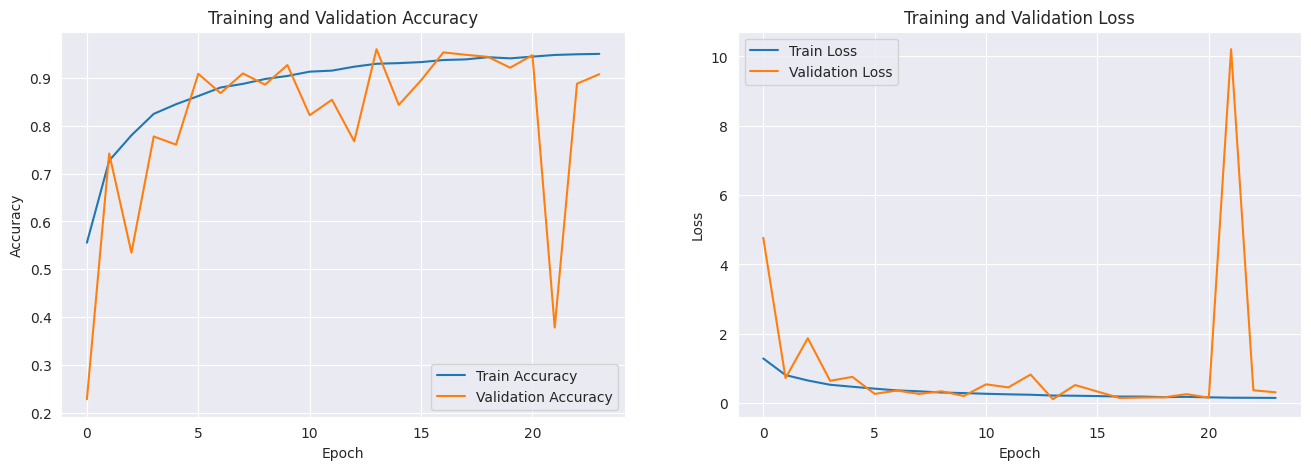

In [20]:
# Plot training history
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

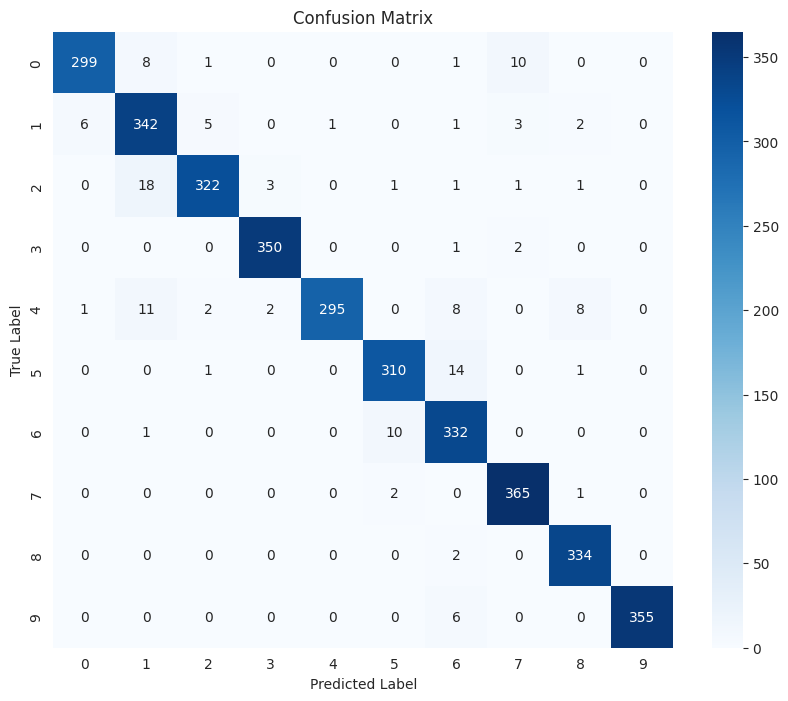

In [21]:
# Confusion Matrix
val_labels = []
val_preds = []

for images, labels in val_dataset:
    val_labels.extend(np.argmax(labels.numpy(), axis=1))
    val_preds.extend(np.argmax(model.predict(images), axis=1))

conf_matrix = confusion_matrix(val_labels, val_preds)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

In [22]:
# ambil nama kelas sebelum diproses lebih lanjut
val_data_raw = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'  # Use categorical labels
)

class_names = val_data_raw.class_names  # Ambil nama kelas di sini

# Lanjutkan preprocessing seperti biasa
val_dataset = val_data_raw.map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)


Found 3440 files belonging to 10 classes.


In [23]:
# Menampilkan hasil klasifikasi berupa matrix evaluasi
print(classification_report(val_labels, val_preds, target_names=class_names))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      0.94      0.96       319
                        Tomato___Early_blight       0.90      0.95      0.92       360
                         Tomato___Late_blight       0.97      0.93      0.95       347
                           Tomato___Leaf_Mold       0.99      0.99      0.99       353
                  Tomato___Septoria_leaf_spot       1.00      0.90      0.95       327
Tomato___Spider_mites Two-spotted_spider_mite       0.96      0.95      0.96       326
                         Tomato___Target_Spot       0.91      0.97      0.94       343
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.96      0.99      0.97       368
                 Tomato___Tomato_mosaic_virus       0.96      0.99      0.98       336
                             Tomato___healthy       1.00      0.98      0.99       361

                                     accu

### Evaluasi

In [24]:
# Evaluasi model pada training, validation, dan test set
train_score = model.evaluate(train_dataset)
val_score = model.evaluate(val_dataset)
test_score = model.evaluate(test_dataset)

# Menampilkan hasil
print(' ')
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", val_score[0])
print("Validation Accuracy: ", val_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


1003/1003 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9676 - loss: 0.0914
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9647 - loss: 0.1005
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9626 - loss: 0.0983
 
Train Loss:  0.09268210828304291
Train Accuracy:  0.9675288200378418
--------------------
Validation Loss:  0.11188856512308121
Validation Accuracy:  0.960465133190155
--------------------
Test Loss:  0.10299565643072128
Test Accuracy:  0.9631350040435791


## Konversi Model

### Saved Model

In [25]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [37]:
shutil.make_archive("saved_model", 'zip', "saved_model")

'/content/saved_model.zip'

In [38]:
files.download("saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TF-Lite

In [27]:
# Buat folder tflite jika belum ada
os.makedirs('tflite', exist_ok=True)

In [28]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('tflite/model.tflite')
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmp5ocy889o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140472360376592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472360377360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472360380240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472360380432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472360376784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472360378512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472360379856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472360381008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472360381392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140472360379280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1404723603812

170700

In [29]:
# Ambil nama kelas dari direktori training
class_names = sorted(os.listdir(train_dir))

# Simpan ke label.txt di folder save_model
with open('tflite/label.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

In [39]:
shutil.make_archive("tflite", 'zip', "tflite")

'/content/tflite.zip'

In [40]:
files.download("tflite.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TFJS

In [32]:
# Convert dan simpan ke folder tfjs_model
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/

2025-04-10 07:13:19.971670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744269200.077885    5662 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744269200.120728    5662 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744269200.184719    5662 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744269200.184773    5662 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744269200.184783    5662 computation_placer.cc:177] computation placer alr

In [41]:
shutil.make_archive("tfjs_model", 'zip', "tfjs_model")

'/content/tfjs_model.zip'

In [42]:
files.download("tfjs_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [43]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Load label
with open("tflite/label.txt", "r") as f:
    class_names = [line.strip() for line in f]

In [60]:
def predict_image(img_path, img_height=128, img_width=128):
    img = Image.open(img_path).resize((img_width, img_height)).convert('RGB')
    img_array = np.array(img) / 255.0
    input_tensor = np.expand_dims(img_array, axis=0).astype(np.float32)

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    interpreter.set_tensor(input_index, input_tensor)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_index)

    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    return img, predicted_class, confidence

In [53]:
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
image_folder = "/content/drive/MyDrive/Daun_Tomato/"

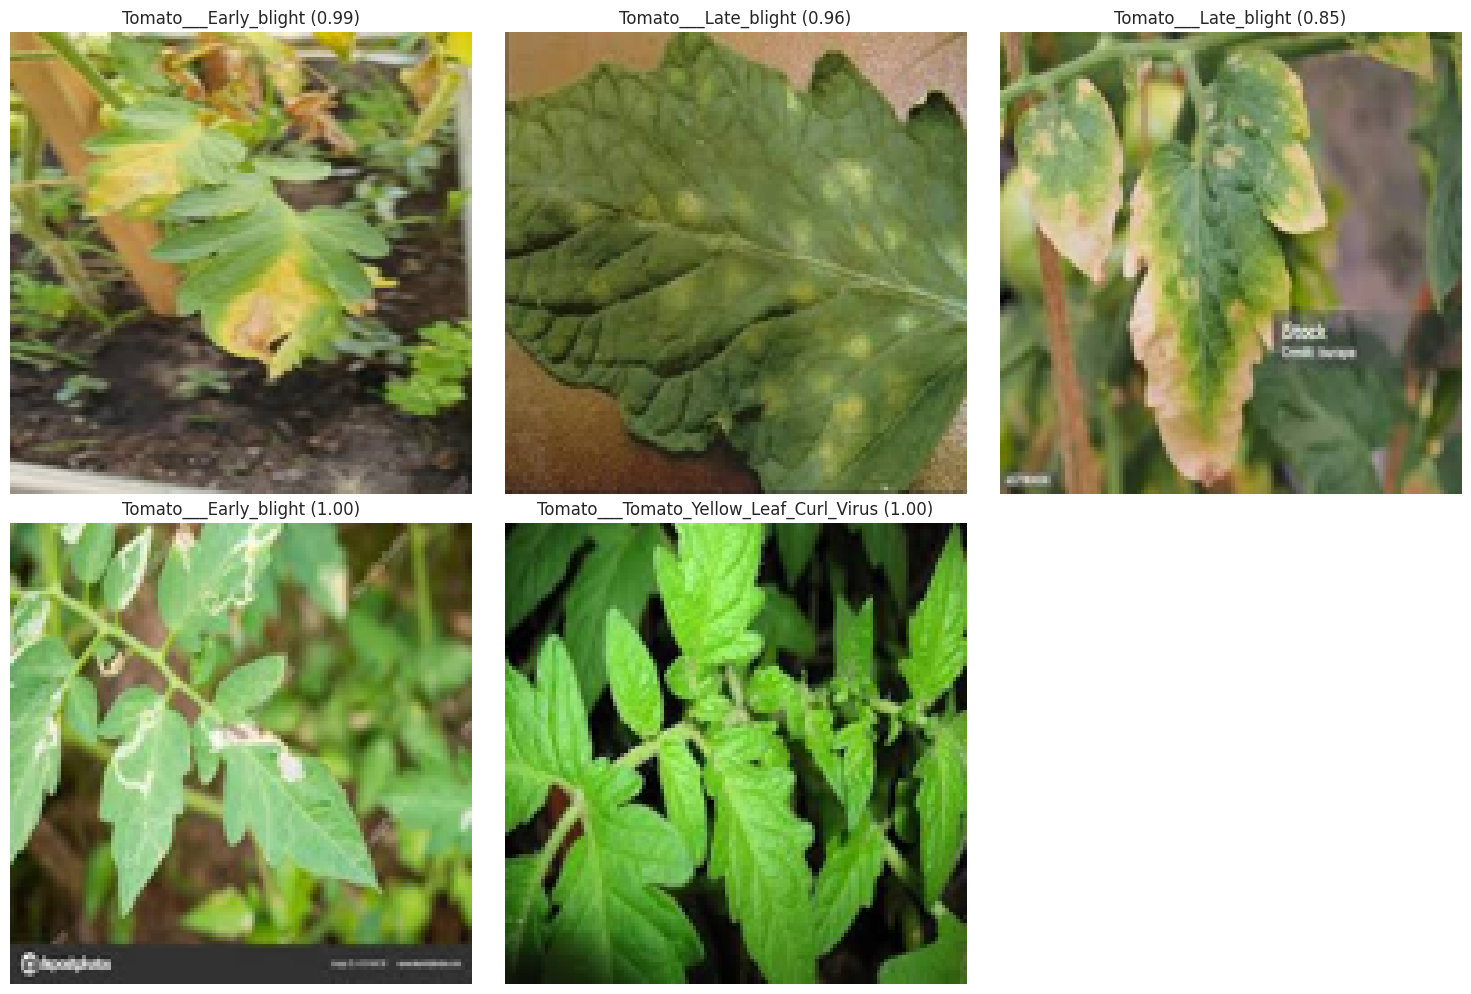

In [61]:
# Ambil semua file gambar
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])[:5]

# Tampilkan semua gambar dengan prediksi
plt.figure(figsize=(15, 10))
for i, file in enumerate(image_files):
    img_path = os.path.join(image_folder, file)
    img, label, conf = predict_image(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{label} ({conf:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()